# Classificatiemodel voor onbekende afdelingen

In dit notebook wordt onderzocht of een eenvoudig machine learning-model in staat is om incidenten met een onbekende hoofdafdeling alsnog toe te wijzen aan een afdeling, op basis van de tekst in **"Beschrijving incident"**.

Dit notebook hoort bij **Bijlage 5 – Machine learning analyse (tekstclassificatie)** van het onderzoeksrapport.

**Packages installeren**

In [1]:
!pip install scikit-learn pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Libraries importeren en data inladen

In deze stap worden de benodigde Python-libraries geïmporteerd en wordt de dataset ingeladen uit het CSV-bestand.

- `pandas` voor het werken met tabellen;
- `scikit-learn` voor het bouwen en evalueren van het model;
- `matplotlib` en `seaborn` voor grafieken.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("default")

# Data inladen
df = pd.read_csv("onbekende-afdelingen voorspellen.csv", sep=",")

print("Vorm van de dataset:", df.shape)
df.head()

Vorm van de dataset: (25758, 3)


,incident nummer,Beschrijving incident,hoofd afdelingen
0,1235359,zwarte Dell boxen plaatsen op kantoor Nierdial...,Marketing
1,1240645,"zwart scherm, error logging in code 70",Commercial department
2,1240473,"Zwart scherm, dus ook het tweede inbouwscherm ...",Commercial department
3,1210261,Zwart scherm nog voor het inloggen,Production A
4,1224306,Zwart scherm na uitloggen,HR advies


## 2. Kolommen opschonen en onbekende afdelingen scheiden

Voordat het model getraind kan worden, wordt de data opgeschoond:

- Tekstvelden worden omgezet naar strings;
- Incidenten met hoofdafdeling *Onbekend* worden gescheiden van incidenten met een bekende afdeling.

De incidenten met bekende afdelingen worden gebruikt om het model te trainen en te testen.
De incidenten met onbekende afdelingen worden later gebruikt om voorspellingen op te doen.

In [3]:
# Tekst altijd als string en geen NaN
df["Beschrijving incident"] = df["Beschrijving incident"].fillna("").astype(str)

# Hoofd afdelingen als string
df["hoofd afdelingen"] = df["hoofd afdelingen"].astype(str)

# Definitie van 'onbekend'
onbekend_waarden = ["Onbekend"]

mask_onbekend = df["hoofd afdelingen"].isin(onbekend_waarden)

bekend = df[~mask_onbekend].copy()
onbekend = df[mask_onbekend].copy()


print("Aantal incidenten met bekende afdeling:", len(bekend))
print("Aantal incidenten met onbekende afdeling:", len(onbekend))

print("\nVerdeling bekende afdelingen:")
print(bekend["hoofd afdelingen"].value_counts())

Aantal incidenten met bekende afdeling: 23838
Aantal incidenten met onbekende afdeling: 1920

Verdeling bekende afdelingen:
hoofd afdelingen
Commercial department    7817
Production A             6779
Production QA            3153
Marketing                2608
Overig                   1589
Facility management      1076
HR advies                 816
Name: count, dtype: int64


## 3. Train–test split

Alleen de incidenten met een bekende hoofdafdeling worden gebruikt om het model te trainen en te evalueren.

- **Input (feature)**: de tekst in *"Beschrijving incident"*
- **Uitkomst (label)**: de waarde in *"hoofd afdelingen"*

De data wordt opgesplitst in:

- 80% trainingsdata;
- 20% testdata.

Met `stratify=y` blijft de verdeling van afdelingen in de train- en testset vergelijkbaar.

In [4]:
X = bekend["Beschrijving incident"]
y = bekend["hoofd afdelingen"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train set:", len(X_train))
print("Test set:", len(X_test))

Train set: 19070
Test set: 4768


## 4. Modelopzet: TF-IDF + Logistic Regression

Het model bestaat uit twee stappen:

1. **TF-IDF vectorisatie**
   De incidentbeschrijvingen worden omgezet in numerieke kenmerken. Hierbij wordt gekeken naar het relatieve belang van woorden in de tekst.

2. **Logistic Regression**
   Een eenvoudig en veelgebruikt classificatiemodel dat de incidenten op basis van de TF-IDF-kenmerken indeelt in afdelingen.

Deze stappen worden gecombineerd in één `Pipeline`, zodat de verwerking overzichtelijk en reproduceerbaar blijft.

In [5]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),  # 1-grams en 2-grams
        min_df=2             # negeer woorden die maar 1x voorkomen
    )),
    ("clf", LogisticRegression(
        max_iter=200,
        n_jobs=-1
    ))
])

## 5. Model trainen

In deze stap wordt het model getraind op de trainingsdata (`X_train`, `y_train`).

In [6]:
pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


## 6. Prestatiemeting op de testset

Het getrainde model wordt getest op `X_test`. We vergelijken de voorspelde afdelingen met de werkelijke afdelingen (`y_test`).

We kijken naar:

- **Accuracy**: welk percentage voorspellingen is exact goed?
- **F1-score**: balans tussen nauwkeurigheid (precision) en volledigheid (recall).
- Een overzicht per afdeling met precision, recall en F1-score.

In [7]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.4

Classification report:
                       precision    recall  f1-score   support

Commercial department       0.40      0.67      0.50      1563
  Facility management       0.35      0.08      0.14       215
            HR advies       0.71      0.06      0.11       163
            Marketing       0.40      0.13      0.20       522
               Overig       0.58      0.02      0.04       318
         Production A       0.42      0.53      0.47      1356
        Production QA       0.28      0.07      0.11       631

             accuracy                           0.40      4768
            macro avg       0.45      0.22      0.22      4768
         weighted avg       0.41      0.40      0.34      4768



## 7. Confusion matrix

De confusion matrix laat zien:

- Rijen: werkelijke afdelingen;
- Kolommen: door het model voorspelde afdelingen;
- Cellen: aantallen incidenten.

Hoe hoger de waarden op de diagonaal, hoe beter. Hoge waarden buiten de diagonaal geven aan dat afdelingen door elkaar worden gehaald.

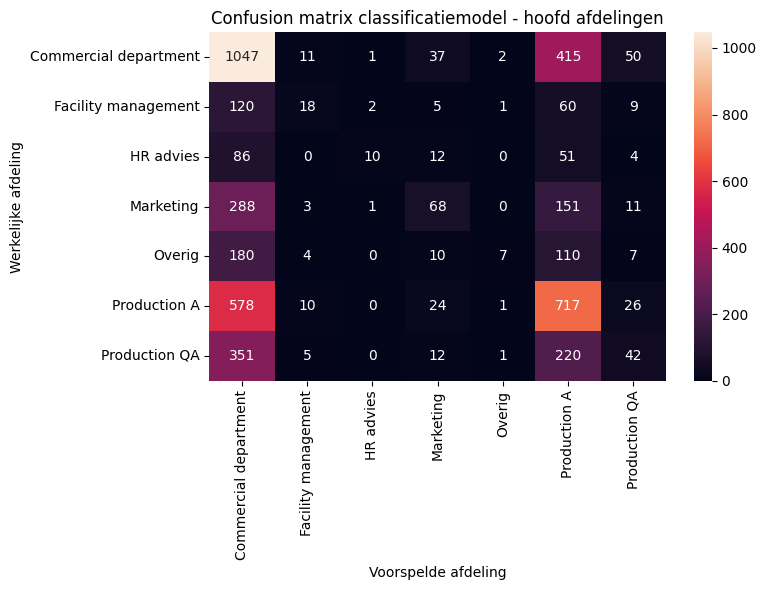

In [8]:
labels = pipeline.classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Voorspelde afdeling")
plt.ylabel("Werkelijke afdeling")
plt.title("Confusion matrix classificatiemodel - hoofd afdelingen")
plt.tight_layout()
plt.show()

## 8. Drempelanalyse voor modelzekerheid

Het model geeft niet alleen een voorspelling, maar ook een **kans** per afdeling (`predict_proba`).
In deze stap wordt onderzocht hoeveel voorspellingen overblijven als we alleen voorspellingen met een zekere minimale modelzekerheid gebruiken (bijv. 0,50 t/m 0,90).

Doel: zien of er een balans te vinden is tussen:

- voldoende voorspellingen (aantal);
- en voldoende betrouwbaarheid (precision, recall, F1).

In [9]:
# Kansverdeling voor de testset
y_test_proba = pipeline.predict_proba(X_test)
classes = pipeline.classes_

def evaluate_thresholds(y_true, y_proba, classes, thresholds):
    """
    Berekent voor elke drempel:
    - aantal voorspellingen (coverage)
    - precision, recall en f1-score (macro)

    Alles onder de drempel wordt behandeld als 'geen voorspelling'.
    """
    y_true = np.array(y_true)
    results = []

    best_idx = y_proba.argmax(axis=1)
    best_prob = y_proba.max(axis=1)
    best_class = classes[best_idx].astype(object)

    for t in thresholds:
        pred = best_class.copy()
        pred[best_prob < t] = None

        mask = pred != None

        if mask.sum() == 0:
            results.append([t, 0, 0.0, 0.0, 0.0])
            continue

        true_filtered = y_true[mask]
        pred_filtered = pred[mask]

        precision = precision_score(true_filtered, pred_filtered, average="macro", zero_division=0)
        recall    = recall_score(true_filtered, pred_filtered, average="macro", zero_division=0)
        f1        = f1_score(true_filtered, pred_filtered, average="macro", zero_division=0)
        coverage  = int(mask.sum())

        results.append([t, coverage, precision, recall, f1])

    cols = ["drempel", "aantal_voorspeld", "precision", "recall", "f1"]
    return pd.DataFrame(results, columns=cols)

**Tabel met drempelwaarden**

In [10]:
thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

df_thresholds = evaluate_thresholds(y_test, y_test_proba, classes, thresholds)
df_thresholds

,drempel,aantal_voorspeld,precision,recall,f1
0,0.50,1130,0.459444,0.296459,0.296504
1,0.55,724,0.455131,0.325494,0.334619
2,0.60,449,0.537997,0.340107,0.346519
3,0.65,282,0.267914,0.254383,0.238580
4,0.70,164,0.267755,0.258914,0.246910
5,0.75,73,0.356087,0.279512,0.289954
6,0.80,23,0.650000,0.666667,0.658120
7,0.85,8,0.437500,0.500000,0.466667
8,0.90,2,1.000000,1.000000,1.000000


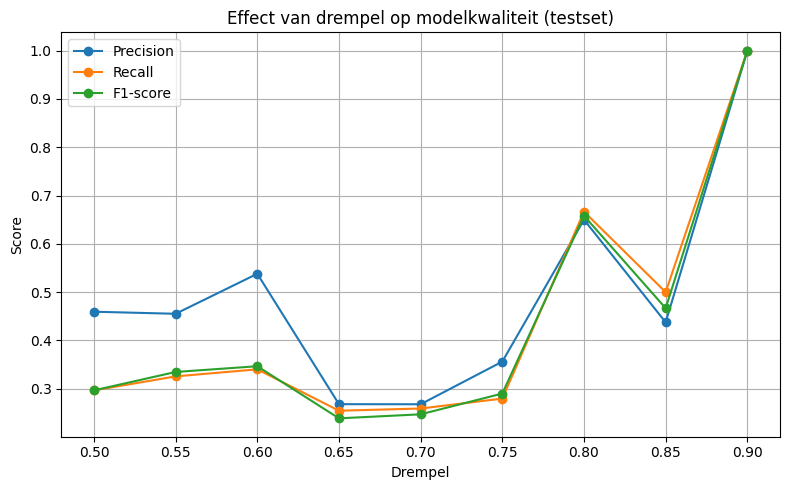

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(df_thresholds["drempel"], df_thresholds["precision"], marker="o", label="Precision")
plt.plot(df_thresholds["drempel"], df_thresholds["recall"],    marker="o", label="Recall")
plt.plot(df_thresholds["drempel"], df_thresholds["f1"],        marker="o", label="F1-score")

plt.xlabel("Drempel")
plt.ylabel("Score")
plt.title("Effect van drempel op modelkwaliteit (testset)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Kiezen van een drempel

Op basis van de drempelanalyse blijkt dat er geen drempel is waarbij het model én betrouwbaar genoeg is én voldoende voorspellingen doet.

Voor de verdere verrijking van de dataset wordt in lijn met de rapportage een drempel van **0,60** gehanteerd. Dat betekent dat alleen voorspellingen met een modelzekerheid van minimaal 60% worden gebruikt.

In [12]:
# Gekozen drempel op basis van de analyse hierboven
drempel = 0.80
drempel

0.8

## 10. Voorspellingen voor onbekende afdelingen

In deze stap wordt het model toegepast op de incidenten waarbij de hoofdafdeling *Onbekend* is.
Voor elk incident wordt de voorspelde afdeling en de modelzekerheid bepaald. Alleen voorspellingen met `model_zekerheid ≥ drempel` worden als bruikbaar beschouwd.

In [13]:
if len(onbekend) > 0:
    proba_onbekend = pipeline.predict_proba(onbekend["Beschrijving incident"])
    best_idx_onb   = proba_onbekend.argmax(axis=1)
    best_prob_onb  = proba_onbekend.max(axis=1)
    best_class_onb = classes[best_idx_onb]

    onbekend["voorspelde_afdeling"] = best_class_onb
    onbekend["model_zekerheid"] = best_prob_onb

    zeker = onbekend[onbekend["model_zekerheid"] >= drempel].copy()
    twijfel = onbekend[onbekend["model_zekerheid"] < drempel].copy()

    print("Incidenten met zekere voorspelling (>= drempel):", len(zeker))
    print("Incidenten met twijfelachtige voorspelling (< drempel):", len(twijfel))

    zeker.head()
else:
    print("Er zijn geen incidenten met onbekende afdeling in deze dataset.")

Incidenten met zekere voorspelling (>= drempel): 7
Incidenten met twijfelachtige voorspelling (< drempel): 1913


## 11. Verrijkte dataset samenstellen

We bouwen nu een verrijkte dataset waarin:

- incidenten met een bekende afdeling hun oorspronkelijke afdeling behouden;
- incidenten met *Onbekend* als hoofdafdeling een voorspelde afdeling krijgen als de modelzekerheid ≥ 0,80 is.

De definitieve afdelingskolom heet `afdeling_eind`.

In [14]:
df_verrijkt = df.copy()

if len(onbekend) > 0:
    voorspellingen = onbekend[["incident nummer", "voorspelde_afdeling", "model_zekerheid"]].copy()

    df_verrijkt = df_verrijkt.merge(
        voorspellingen,
        on="incident nummer",
        how="left"
    )

# Nieuwe kolom: afdeling_eind
df_verrijkt["afdeling_eind"] = df_verrijkt["hoofd afdelingen"]

mask_eind_onbekend = df_verrijkt["hoofd afdelingen"].isin(onbekend_waarden)

if "model_zekerheid" in df_verrijkt.columns:
    df_verrijkt.loc[
        mask_eind_onbekend & df_verrijkt["model_zekerheid"].ge(drempel),
        "afdeling_eind"
    ] = df_verrijkt.loc[
        mask_eind_onbekend & df_verrijkt["model_zekerheid"].ge(drempel),
        "voorspelde_afdeling"
    ]

print("Verdeling originele hoofd afdelingen:")
print(df["hoofd afdelingen"].value_counts(dropna=False))

print("\nVerdeling na verrijking (afdeling_eind):")
print(df_verrijkt["afdeling_eind"].value_counts(dropna=False))

# Optioneel opslaan
df_verrijkt.to_csv("onbekende-afdelingen voorspellen_verrijkt.csv", index=False)

Verdeling originele hoofd afdelingen:
hoofd afdelingen
Commercial department    7817
Production A             6779
Production QA            3153
Marketing                2608
Onbekend                 1920
Overig                   1589
Facility management      1076
HR advies                 816
Name: count, dtype: int64

Verdeling na verrijking (afdeling_eind):
afdeling_eind
Commercial department    7818
Production A             6785
Production QA            3153
Marketing                2608
Onbekend                 1913
Overig                   1589
Facility management      1076
HR advies                 816
Name: count, dtype: int64


## 12. Effect van verrijking op onbekende incidenten

Tot slot wordt inzichtelijk gemaakt welk deel van de incidenten met een onbekende afdeling door het model is aangevuld, en welk deel onbekend is gebleven.

In [15]:
# Definitief effect meten
onbekend_voor = df["hoofd afdelingen"].isin(onbekend_waarden).sum()
onbekend_na = df_verrijkt["afdeling_eind"].isin(onbekend_waarden).sum()
nieuw_aangevuld = onbekend_voor - onbekend_na
percentage = (nieuw_aangevuld / onbekend_voor) * 100 if onbekend_voor > 0 else 0

print("Onbekend voor verrijking:", onbekend_voor)
print("Onbekend na verrijking:", onbekend_na)
print("Nieuw aangevuld:", nieuw_aangevuld)
print(f"Percentage aangevuld: {percentage:.2f}%")

Onbekend voor verrijking: 1920
Onbekend na verrijking: 1913
Nieuw aangevuld: 7
Percentage aangevuld: 0.36%
